In [1]:
from dotenv import load_dotenv
load_dotenv()#'../.env')

False

In [2]:
from langchain_core.messages import AIMessage, BaseMessage
from langgraph.graph.message import add_messages
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)

In [3]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

In [4]:
llm.invoke("what's the weather in sf?")

AIMessage(content="I'm not able to provide real-time weather information. However, I can give you general information about San Francisco's climate.\n\nSan Francisco is known for its cool and foggy climate, with temperatures ranging from 40°F (4°C) to 70°F (21°C) throughout the year. The city experiences a Mediterranean climate, with cool, wet winters and mild, dry summers.\n\nIf you're looking for the current weather in San Francisco, I recommend checking a weather website or app, such as AccuWeather or Weather.com, for the most up-to-date information.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 42, 'total_tokens': 159, 'completion_time': 0.468, 'prompt_time': 0.010875114, 'queue_time': 0.6078694370000001, 'total_time': 0.478875114}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-6903be60-8865-4e3f-b1da-05ae2075d7ad-0', usage_metadata={'input_t

In [5]:
from langchain_core.tools import tool

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ['sf','san francisco', 'dallas']]):
        return f"It's sunny in the {location}."#, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"

tools = [get_weather]
model = llm.bind_tools(tools)

In [6]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]


tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state['messages'][-1].tool_calls:  # calling any tools found in message state.
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"]
        )
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Define the node that calls the model
def call_model(state: AgentState, config: RunnableConfig,):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage("You are a helpful AI assistant, please respond to the users query to the best of your ability!. If you couldnt reply, say 'I am sorry")
    response = model.invoke([system_prompt] + state['messages'], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if last_message.tool_calls:
        return "tools"
    # Otherwise if there is, we continue
    else:
        return "end"

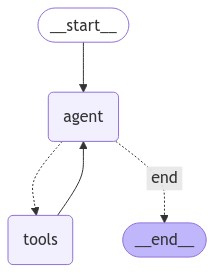

In [7]:
from langgraph.graph import StateGraph, END
from langgraph.constants import END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
#workflow.set_entry_point("agent")
workflow.add_edge("__start__", "agent")
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "tools": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_rpth)
 Call ID: call_rpth
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's sunny in the San Francisco."
================================== Ai Message ==================================

The current weather in San Francisco is sunny.
